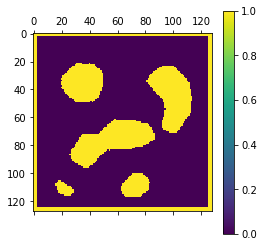

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import math
from skimage.draw import line

# Load grid map
image = Image.open('map0.png').convert('L')
grid_map = np.array(image.getdata()).reshape(image.size[0],image.size[1])/255
# binarize the image
grid_map[grid_map > 0.5] = 1
grid_map[grid_map <= 0.5] = 0
# Invert colors to make 0 -> free and 1 -> occupied
grid_map = (grid_map * -1) + 1
# Show grid map
plt.matshow(grid_map)
plt.colorbar()
plt.show()

# **The RRT algorithm**

In [ ]:
def PixelCoordinatesOfLine(p1, p2, vertices):
  # a function to get the pixels in the image between any two arbitrary points (p1 and p2) in the image
  if isinstance(p2, int) or isinstance(p2, np.int64):
    a=p2
  else:
    a=p2[0]
  ROWS, COLUMNS = line(vertices[p1][0], vertices[p1][1], vertices[a][0], vertices[a][1])
  return ROWS, COLUMNS

In [ ]:
def RAND_CONF(p, vertices):
  # Choose a rondom vertex with some predifined probabilities
  prob= [(1-p)/(len(vertices)-1)] * len(vertices)
  prob[-1]=p
  r = np.random.choice(list(range(len(vertices))), 1, p=prob)
  return r

In [ ]:
def NEAREST_VERTEX(qrand, G_Verteices, vertices):
  # a function to compute the nearest pixel to the randomly selected pixel(vertex) by the RAND_CONF function
  if isinstance(qrand, int) or isinstance(qrand, np.int64):
    qrand=qrand
  else:
    qrand=qrand[0]
  distance= 10000000
  for i in range(len(G_Verteices)):
    if math.dist(vertices[qrand], vertices[G_Verteices[i]]) < distance:
      distance =  math.dist(vertices[qrand], vertices[G_Verteices[i]])
      index= i
  return G_Verteices[index]


In [ ]:
def NEW_CONF(qnear, qrand, delta_q, vertices):
  # a function to make sure that the randomly selected pixel (qrand) is with in the allowable distance (delta_q)
  # from the nearest pixel (qnear). And if this condition is not met it selects new pixel with in the allowable
  # distance (delta_q) that lies in the straight line that connects qnear, qrand.
  if isinstance(qrand, int) or isinstance(qrand, np.int64):
    qrand=qrand
  else:
    qrand=qrand[0]

  if isinstance(qnear, int) or isinstance(qnear, np.int64):
    qnear=qnear
  else:
    qnear=qnear[0]

  if math.dist(vertices[qrand], vertices[qnear]) <= delta_q:
    return qrand
  else:
    #rows, columns = PixelCoordinatesOfLine(qnear, qrand, vertices)
    rows, columns = PixelCoordinatesOfLine(qrand,qnear, vertices)
    for i in range(len(rows)):
      if math.dist([rows[i],columns[i]], vertices[qnear]) < delta_q and IS_SEGMENT_FREE(qnear, [rows[i],columns[i]], vertices):
        continue
      else:
        a=[rows[i-1],columns[i-1]]
        for j in range (len(vertices)):
          if a==vertices[j]:
            return j


In [ ]:
def IS_SEGMENT_FREE(qnear, qnew, vertices):
  # a funciton that checks if the straight line that connects (qnear and qnew) doesn't interest an obstacle
  if isinstance(qnew, list):
    a=[qnew[0],qnew[1]]
    for j in range (len(vertices)):
      if a==vertices[j]:
        new=j
        break
    qnew = new
  rows, columns = PixelCoordinatesOfLine(qnear, qnew, vertices)
  for i in range(len(rows)):
    a=[rows[i],columns[i]]
    if a in vertices:
      flag=True
    else:
      flag=False
      return flag
  return flag


In [ ]:
def FILL_PATH(G_Verteices,G_Edges,vertices):
  # a function that extracts the path from the graph of vertices computed by the RRT algorithm
  path=[len(vertices)-1]
  for i in range(len(G_Edges)):
    j=i+1
    if path[0]== G_Edges[-1*j][1]:
      pointer= G_Edges[-1*j][0]
      if pointer not in path:
        path.insert(0, pointer)
        if pointer==0:
          return path

In [ ]:
def total_path_dist(nodes , vertices):
  # a function that computes the distance of the path that goes from qstart to qgoal
  distance=0
  for i in range(len(nodes)-1):
    ver1= vertices[nodes[i]]
    ver2=vertices[nodes[i+1]]
    distance = distance + math.dist(ver1, ver2)
  return distance

In [ ]:
def RRT(C, K, delta_q, p, qstart, qgoal):

  G_Verteices= [0] # stores all the vertices in the graph formed by the RRT algorithm
  G_Edges=[] # stores all the edges that connects the vertices in the graph formed by the RRT algorithm
  c=np.shape(C) # This is the map or environment upon which the RRT algorithm is applied
  vertices=[] # all the pixels of the image that are on the free spaces


  indicator_start=0 # indicator used to check if the given starting point is in free space
  indicator_goal=0 # indicator used to check if the given goal point is in free space

  # storing all the free space of the map in the variable called vertices
  for i in range(c[0]):
    for j in range(c[1]):
      if C[i][j]==0:
        vertices.append([i,j])

  # sorting the vertices i.e making the starting vertex in the first position of the vertices  variable
  for i in range (len(vertices)):
    if qstart==vertices[i]:
      temp_store = vertices[0]
      vertices[0] = vertices[i]
      vertices[i] = temp_store
      indicator_start=1
      break

  # sorting the vertices i.e making the goal vertex at the last position of the vertices  variable
  for i in range (len(vertices)):
    if qgoal==vertices[i]:
      temp_store = vertices[-1]
      vertices[-1] = vertices[i]
      vertices[i] = temp_store
      indicator_goal=1
      break

  if not indicator_goal and indicator_start:
    print("Either the given starting point or the goal point or both is/are inside an obstacle! ")
    return None

  for i in range(K):
    qrand = RAND_CONF(p, vertices)
    qnear = NEAREST_VERTEX(qrand, G_Verteices,vertices)
    qnew = NEW_CONF(qnear, qrand, delta_q, vertices)

    if IS_SEGMENT_FREE(qnear, qnew, vertices):
      if qnew not in G_Verteices:
        G_Verteices.append(qnew)
      if [qnear, qnew] not in G_Edges:
        G_Edges.append([qnear, qnew])

      if vertices[qnew] == vertices[-1]:
        PATH = FILL_PATH(G_Verteices,G_Edges,vertices)
        print("Path Found after ", i, "Iterations")
        print("The total distance is: ", total_path_dist(PATH , vertices))
        print("The Path to Follow is: ")
        for j in range(len(PATH)):
          print(vertices[PATH[j]])
        print("The chosen vertices to form the path are:")
        print(PATH)
        return PATH, vertices, G_Edges
      if math.dist(vertices[qnew], vertices[-1]) <= delta_q and IS_SEGMENT_FREE((len(vertices)-1), qnew, vertices):
        if (len(vertices)-1) not in G_Verteices:
          G_Verteices.append(len(vertices)-1)
        if [qnew, (len(vertices)-1)] not in G_Edges:
          G_Edges.append([qnew, (len(vertices)-1)])
        PATH = FILL_PATH(G_Verteices,G_Edges,vertices)
        print("Path Found after ", i, "Iterations")
        print("The total distance is: ", total_path_dist(PATH , vertices))
        print("The Path to Follow is: ")
        for j in range(len(PATH)):
          print(vertices[PATH[j]])
        print("The chosen vertices to form the path are:")
        print(PATH)
        return PATH, vertices , G_Edges

  return print("No solution found")

In [ ]:
[path,vertices_list, edge] = RRT(grid_map, 10000, 10, 0.2, qstart=[10, 10], qgoal=[90, 70])

Path Found after  2336 Iterations
The total distance is:  170.04714577128436
The Path to Follow is: 
[10, 10]
[9, 16]
[11, 25]
[10, 32]
[6, 39]
[5, 45]
[7, 50]
[9, 51]
[17, 52]
[22, 46]
[25, 48]
[30, 56]
[38, 59]
[39, 68]
[46, 73]
[50, 81]
[49, 83]
[55, 88]
[62, 91]
[71, 88]
[73, 91]
[79, 88]
[85, 86]
[84, 78]
[90, 70]
The chosen vertices to form the path are:
[0, 745, 998, 883, 402, 286, 535, 780, 1757, 2356, 2665, 3074, 3597, 3671, 4179, 4544, 4444, 5067, 5797, 6494, 6643, 7053, 7544, 7439, 11803]


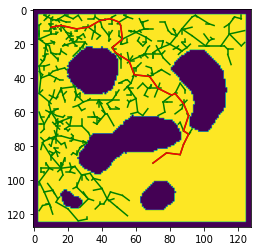

In [ ]:
# Plotting the optimal path computed
x=[]
y=[]
optimal_path=[]
for i in range(len(path)):
  optimal_path.append(vertices_list[path[i]])
for j in range(len(optimal_path)):
  v=optimal_path[j]
  x.append(v[0])
  y.append(v[1])

x=np.array(x)
y=np.array(y)


w=[]
z=[]
branches=[]
for i in range(len(edge)):
  coord1=vertices_list[edge[i][0]]
  coord2=vertices_list[edge[i][1]]
  w=[coord1[0],coord2[0]]
  z=[coord1[1],coord2[1]]
  plt.plot(z, w, marker='', color="green")

plt.plot(y, x, marker='', color="red")
plt.imshow(image)
plt.show()

In [ ]:
# Smoothing the computed path
optimal_path_new=[vertices_list[path[len(path) - 1]]]
s= len(path) - 1
st=[]
a=[]
while vertices_list[0] not in optimal_path_new:
  for j in range(len(path)):
    if IS_SEGMENT_FREE(path[s], path[j], vertices_list):
      optimal_path_new.append(vertices_list[path[j]])
      s=j
      st.append(s)
      break

print("The smoothed distance is: ")
print(total_path_dist(st , vertices_list))
print("The Path to Follow is: ")
for i in range(len(optimal_path_new)):
  #a.append([optimal_path_new[len(optimal_path_new)-1-i]])
  print(optimal_path_new[len(optimal_path_new)-1-i])
#print(a)

The smoothed distance is: 
23.61577310586391
The Path to Follow is: 
[10, 10]
[6, 39]
[73, 91]
[90, 70]


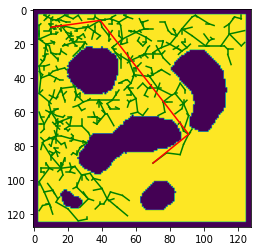

In [ ]:
# Plotting the computed optimized path
x=[]
y=[]

for j in range(len(optimal_path_new)):
  v=optimal_path_new[j]
  x.append(v[0])
  y.append(v[1])

x=np.array(x)
y=np.array(y)


w=[]
z=[]
branches=[]
for i in range(len(edge)):
  coord1=vertices_list[edge[i][0]]
  coord2=vertices_list[edge[i][1]]
  w=[coord1[0],coord2[0]]
  z=[coord1[1],coord2[1]]
  plt.plot(z, w, marker='', color="green")

plt.plot(y, x, marker='', color="red")
plt.imshow(image)
plt.show()